In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.api import VAR, VECM
from scipy.stats import pearsonr
import numpy as np

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib agg
fig, ax = plt.subplots(figsize=(12,6))

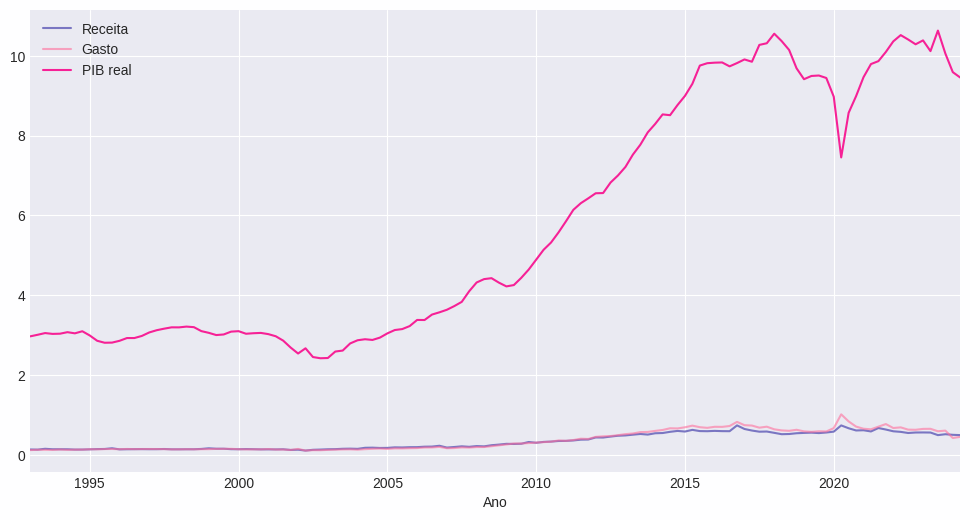

In [2]:
ax.clear()

df_raw = pd.read_parquet('../data/for_the_model_per_capita.parquet')

df_raw.plot(ax=ax)

ax.legend(['Receita', 'Gasto', 'PIB real'])

ax.set(
	xlabel='Ano'
)

fig

## Normalize the data

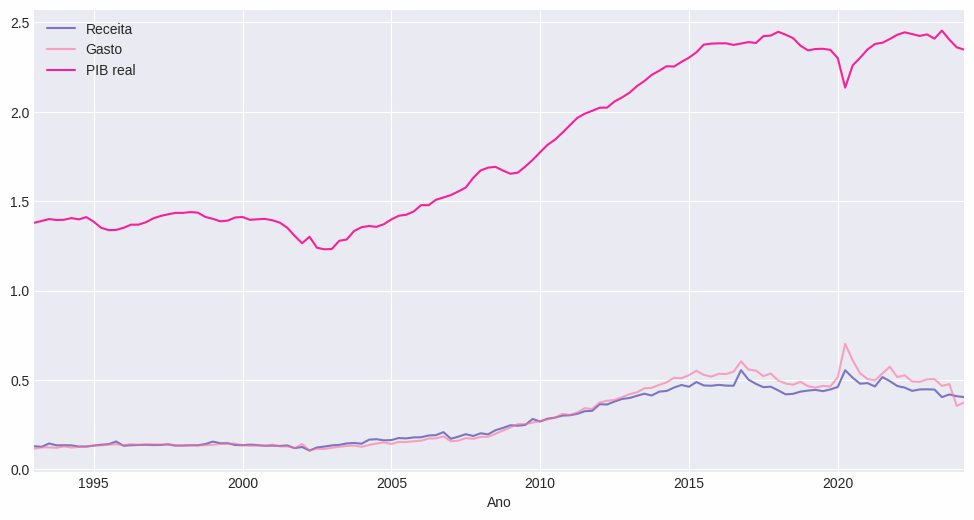

In [3]:
ax.clear()

df_log = np.log(df_raw + 1)

df_log.plot(ax=ax)

ax.legend(['Receita', 'Gasto', 'PIB real'])

ax.set(
	xlabel='Ano',
)

fig

In [4]:
df_log.corr()

,revenue_adj,expenditure_adj,gdp_real
revenue_adj,1.000000,0.993199,0.977497
expenditure_adj,0.993199,1.000000,0.967903
gdp_real,0.977497,0.967903,1.000000


### VECM

In [5]:
df_for_the_model = df_log

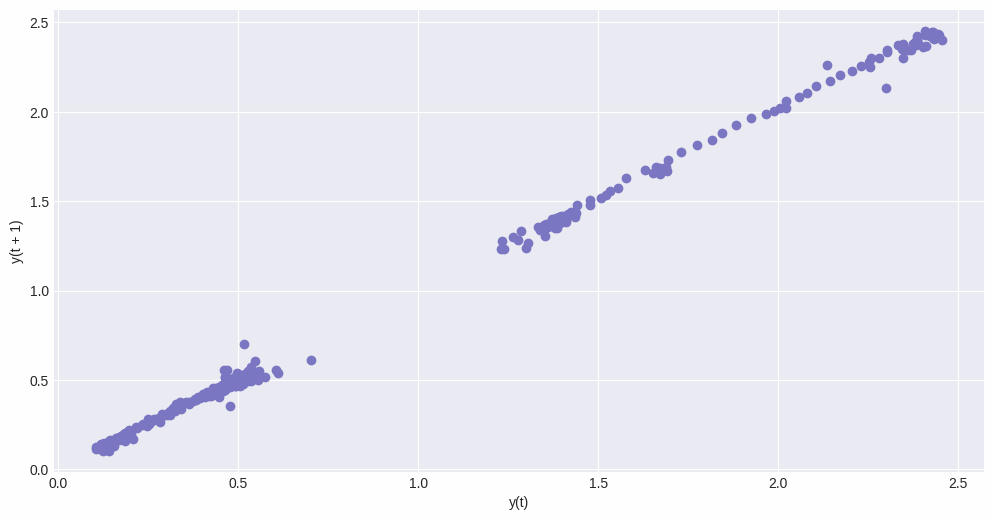

In [6]:
ax.clear()
pd.plotting.lag_plot(df_for_the_model, ax=ax)
fig

In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_order, select_coint_rank

def cointegration_test(df, alpha=0.05): 
	"""Perform Johanson's Cointegration Test and Report Summary"""
	out = coint_johansen(df, det_order=0, k_ar_diff=1)
	d = {'0.90':0, '0.95':1, '0.99':2}
	traces = out.lr1
	cvts = out.cvt[:, d[str(1-alpha)]]
	def adjust(val, length= 6): return str(val).ljust(length)

	# Summary
	print('Name   ::  Test Stat > C(95%)	=>   Signif  \n', '--'*20)
	for col, trace, cvt in zip(df.columns, traces, cvts):
		print(adjust(col, 18), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_for_the_model)

Name   ::  Test Stat > C(95%)	=>   Signif  
 ----------------------------------------
revenue_adj        ::  67.34     > 29.7961   =>   True
expenditure_adj    ::  20.73     > 15.4943   =>   True
gdp_real           ::  0.03      > 3.8415    =>   False


In [8]:
lag_order = select_order(
	df_for_the_model,
	maxlags=20,
	deterministic='ci'
)

rank_test = select_coint_rank(
	df_for_the_model,
	det_order=1,
	k_ar_diff=2
)

/home/carneiro/personal/insper/tcc/lab/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/carneiro/personal/insper/tcc/lab/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/carneiro/personal/insper/tcc/lab/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/carneiro/personal/insper/tcc/lab/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/carneiro/personal/insper/tcc/l

In [9]:
optimal_lag = lag_order.aic
print(
	f'Número ótimo de defasagens: {optimal_lag}',
	f'Rank da cointegraçao: {rank_test.rank}',
	sep='\n'
)

Número ótimo de defasagens: 20
Rank da cointegraçao: 2


In [10]:
vecm = VECM(
	df_for_the_model,
	k_ar_diff=optimal_lag,
	coint_rank=rank_test.rank,
	deterministic='ci',
	seasons=4
)
vecm_fit = vecm.fit()
vecm_fit.summary()

/home/carneiro/personal/insper/tcc/lab/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


,coef,std err,z,P>|z|,[0.025,0.975]
season1,-0.0033,0.005,-0.690,0.490,-0.013,0.006
season2,0.0029,0.005,0.528,0.597,-0.008,0.014
season3,0.0003,0.005,0.068,0.946,-0.009,0.009
L1.revenue_adj,-0.2116,0.504,-0.420,0.674,-1.199,0.775
L1.expenditure_adj,0.2820,0.385,0.733,0.464,-0.472,1.036
L1.gdp_real,-0.2705,0.099,-2.736,0.006,-0.464,-0.077
L2.revenue_adj,0.1469,0.517,0.284,0.776,-0.866,1.160
L2.expenditure_adj,0.4303,0.401,1.073,0.283,-0.356,1.216
L2.gdp_real,-0.0144,0.107,-0.134,0.893,-0.224,0.195
L3.revenue_adj,0.2083,0.531,0.393,0.695,-0.831,1.248


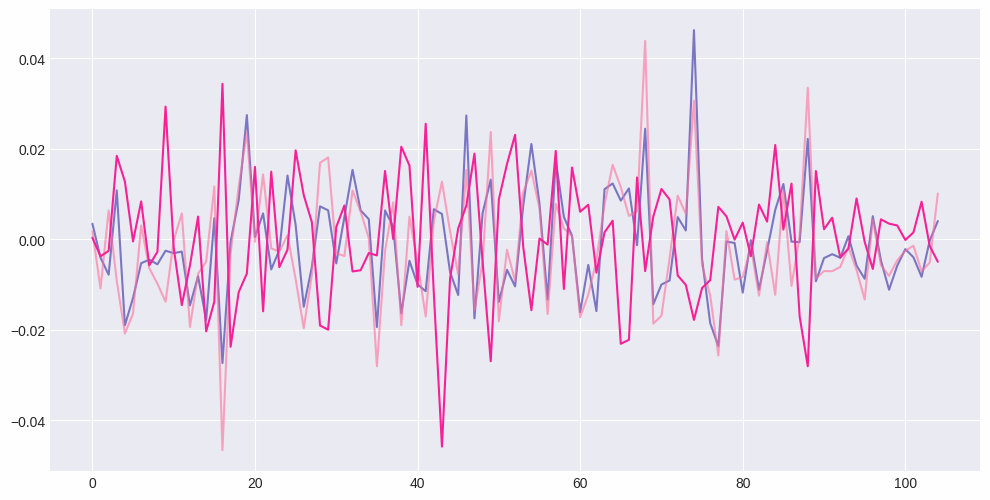

In [11]:
ax.clear()
# Resíduos do modelo
residuals = pd.DataFrame(vecm_fit.resid)

# Plotar os resíduos
ax.plot(residuals)

fig

In [126]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, normal_ad
from scipy.stats import shapiro

# Teste de Ljung-Box para autocorrelação
for col in residuals:
	lb_test = acorr_ljungbox(residuals[col], lags=[20], return_df=True)
	# bp_test = het_breuschpagan(residuals, vecm_fit.model.exog_names)
	ad_test = normal_ad(residuals[col], axis=0)
	shapiro_test = shapiro(residuals[col])
	
	print(f'Resíduos de {col}')
	print(f'Ljung-Box: {lb_test.lb_pvalue.values[0]:.4f}')
	
	# print('Breusch-Pagan test:', bp_test)
	
	print(f'Anderson-Darling: {ad_test[1]:.4f}')

	# print(f'Shapiro: {shapiro_test.pvalue:.2f}')
	
	print('\n')



Resíduos de 0
Ljung-Box: 0.9372
Anderson-Darling: 0.0773


Resíduos de 1
Ljung-Box: 0.7587
Anderson-Darling: 0.0778


Resíduos de 2
Ljung-Box: 0.6036
Anderson-Darling: 0.7422




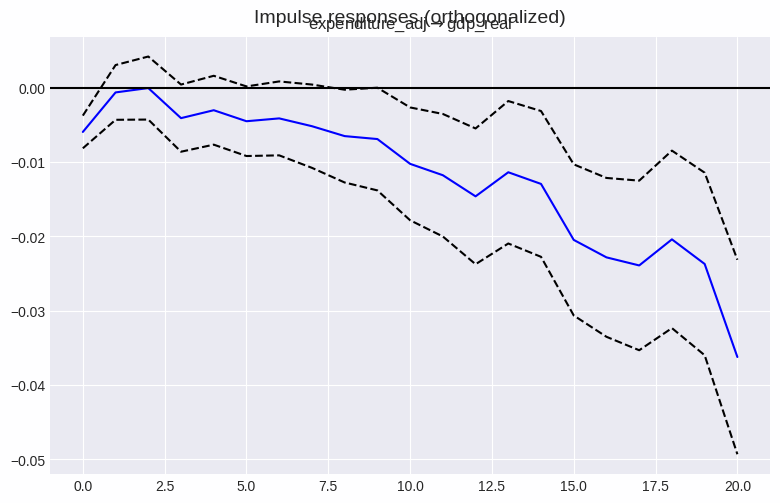

In [13]:
ax.clear()

irf = vecm_fit.irf(periods=20)
irf.plot(
	orth=True,
	plot_stderr=True,
	impulse='expenditure_adj',
	response='gdp_real',
	figsize=(8,5)
)

In [14]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 20
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, maxlag, test):
	df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
	for c in df.columns:
	    for r in df.index:
	   	 test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag)
	   	 p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
	   	 min_p_value = np.min(p_values)
	   	 df.loc[r, c] = min_p_value
	df.columns = [var + '_x' for var in variables]
	df.index = [var + '_y' for var in variables]
	return df

# Matriz de causalidade
causality_matrix = grangers_causation_matrix(df_for_the_model, variables=df_for_the_model.columns, maxlag=maxlag, test=test)
causality_matrix


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=123, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=7186.3717, p=0.0000  , df_denom=123, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=121, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=3653.8468, p=0.0000  , df_denom=121, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=119, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=3
parameter F test:         F=2394.7597, p=0.0000  , df_denom=119, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0000  , p=1.000

,revenue_adj_x,expenditure_adj_x,gdp_real_x
revenue_adj_y,1.0,0.0,0.0039
expenditure_adj_y,0.0,1.0,0.0000
gdp_real_y,0.0,0.0,1.0000


# Equation time

### alpha

In [125]:
vecm_fit.names

['revenue_adj', 'expenditure_adj', 'gdp_real']

### beta

In [33]:
vecm_fit.beta

array([[ 1.00000000e+00, -3.10444250e-18],
       [-1.38608408e-16,  1.00000000e+00],
       [-3.24679430e-01, -3.83193916e-01]])

### constantes

In [36]:
vecm_fit.const_coint

array([[0.30345431, 0.38366185]])

### Gamma

In [68]:
mgamma = pd.concat([pd.DataFrame(vecm_fit.gamma).melt(value_name='gamma').gamma, pd.DataFrame(vecm_fit.pvalues_gamma).melt(value_name='pvalue').pvalue], axis=1)

In [102]:
mgamma

,gamma,pvalue
0,-0.211616,6.743498e-01
1,1.329935,1.894129e-02
2,-2.872237,3.775195e-07
3,0.281995,4.637494e-01
4,-1.107679,1.054154e-02
...,...,...
175,-0.618162,3.734582e-02
176,-0.266195,3.688433e-01
177,-0.238672,8.114625e-03
178,-0.170771,9.233192e-02


In [124]:
latex_table = "\\begin{table}[h!]\n" \
              "    \\centering\n" \
              "    \\caption*{Coeficientes e $p$-valores de $\\mathbf{\\Gamma}$\n" \
              "    \\begin{tabular}{|c|c|c|}\n" \
              "        \\hline\n" \
              "        \\textbf{Coeficiente} & \\textbf{Valor} & \\textbf{$p$-valor} \\\\\n" \
              "        \\hline\n"

for i, (gamma, pval) in enumerate(zip(mgamma.gamma, mgamma.pvalue)):
	latex_table += f"        $\\gamma_{{{(i//3)%3 + 1}{i%3+1},{i//9+1}}}$ & {gamma:.4f} & {pval:.4f} \\\\\n        \\hline\n"
	# print(f'{(i//3)%3 + 1} {i%3+1} {i//9+1}') #, {gamma:.4f}, {pval:.4f}')

latex_table += "    \\end{tabular}\n" \
               "\\end{table}"

print(latex_table)

\begin{table}[h!]
    \centering
    \caption*{Coeficientes e $p$-valores de $\mathbf{\Gamma}$
    \begin{tabular}{|c|c|c|}
        \hline
        \textbf{Coeficiente} & \textbf{Valor} & \textbf{$p$-valor} \\
        \hline
        $\gamma_{11,1}$ & -0.2116 & 0.6743 \\
        \hline
        $\gamma_{12,1}$ & 1.3299 & 0.0189 \\
        \hline
        $\gamma_{13,1}$ & -2.8722 & 0.0000 \\
        \hline
        $\gamma_{21,1}$ & 0.2820 & 0.4637 \\
        \hline
        $\gamma_{22,1}$ & -1.1077 & 0.0105 \\
        \hline
        $\gamma_{23,1}$ & 2.5813 & 0.0000 \\
        \hline
        $\gamma_{31,1}$ & -0.2705 & 0.0062 \\
        \hline
        $\gamma_{32,1}$ & -0.4853 & 0.0000 \\
        \hline
        $\gamma_{33,1}$ & 0.6206 & 0.0000 \\
        \hline
        $\gamma_{11,2}$ & 0.1469 & 0.7763 \\
        \hline
        $\gamma_{12,2}$ & 1.6585 & 0.0044 \\
        \hline
        $\gamma_{13,2}$ & -2.8592 & 0.0000 \\
        \hline
        $\gamma_{21,2}$ & 0.4303 & 0.2832 \\
     